<a href="https://colab.research.google.com/github/eedduu/TFG/blob/main/code/old_playgrounds/LeNet5_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pygad>=2.10.0

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pygad.torchga
import numpy as np
import pygad.cnn
import pygad.gacnn
import pygad
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt


In [ ]:
batch_size = 64
n_classes = 10
lr = 0.001
n_epochs = 10

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor()
                                                  ]),
                                           download = True)


test_dataset = torchvision.datasets.MNIST(root = './data',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                 # transforms.Normalize(mean = (0.1325,), std = (0.3105,))
                                                 ]),
                                          download=True)


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = 1, #puro sgd
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 117990133.11it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39151807.96it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 61861153.67it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6922430.51it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
#Definimos la red LeNet5
#Heredamos de nn.Module (modulo de las redes neuronales) para que tenga los metodos que necesitamos

class LeNet5(nn.Module):
    #Iniciamos creando una ConvNet y luego creamos las capas (no hace falta ponerlas en orden pero es mucho más intuitivo)
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        #Con sequential podemos agrupar varias capas (convolucion y pooling) en una sola
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        #Aqui tambien podríamos haber agrupado las capas full conected en una sola con sequential
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, n_classes)

    #Esto define lo que sale de una capa y entra en otra
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [ ]:
#Creo la red con un output de 10 y lo conecto al disp (gpu si disponible cpu sino)
model = LeNet5(n_classes).to(device)

#Elijo la función de coste como CrossEntropy ya que tengo varios labels distintos
cost = nn.CrossEntropyLoss()

#Elijo el algoritmo de optimizacion que voy a usar
optimizer = torch.optim.SGD(model.parameters(), lr=lr)




In [ ]:
############ SGD PURO ################
epochs=4

lrv = [0.001, 0.0025, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05,  0.06, 0.07, 0.08, 0.09]

#0.045<x<0.08


for lr in lrv:
  model = LeNet5(n_classes).to(device)
  train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = 1, #puro sgd
                                            shuffle = True)

  optimizer = torch.optim.SGD(model.parameters(), lr=lr)



  errores = np.array(2.0)
  for j in range(epochs):
    enum = enumerate(train_loader)
    for i in range(len(train_loader)):
      #Convierto las imagenes según el dispositivo que uso
      aux, (images, labels) = next(enum)
      images = images.to(device)
      labels = labels.to(device)

      ## Paso adelante
      #Hago una prediccion
      outputs = model(images)

      #Calculo la funcion de coste
      loss = cost(outputs, labels)

      ##Paso atras
      #Reseteo los gradientes de la iteracion anterior.
      optimizer.zero_grad()
      #Calculo los nuevos gradientes
      loss.backward()
      #Actualizo los pesos (para llamar a ésta función tengo que haber llamado antes a backward())
      optimizer.step()

      errores = np.append(errores, loss.item())

      if i%20000==0:
        print ('Learning rate: {}, Step [{}/{}], epoch[{}/5] Loss: {:.4f}'
                  .format(lr, i, epochs, j+1, loss.item()))
    print("media de los errores en epoch {} : {}".format(j+1, np.mean(errores) ))

  plt.plot(errores)
  plt.title("Learning rate {}".format(lr))
  plt.show()



Learning rate: 0.001, Step [0/4], epoch[1/5] Loss: 2.4359
Learning rate: 0.001, Step [20000/4], epoch[1/5] Loss: 0.0208
Learning rate: 0.001, Step [40000/4], epoch[1/5] Loss: 0.0215
media de los errores en epoch 1 : 0.22771114295787953
Learning rate: 0.001, Step [0/4], epoch[2/5] Loss: 0.0042
Learning rate: 0.001, Step [20000/4], epoch[2/5] Loss: 0.0026
Learning rate: 0.001, Step [40000/4], epoch[2/5] Loss: 0.0083
media de los errores en epoch 2 : 0.14610531474467311
Learning rate: 0.001, Step [0/4], epoch[3/5] Loss: 0.0940
Learning rate: 0.001, Step [20000/4], epoch[3/5] Loss: 0.0002
Learning rate: 0.001, Step [40000/4], epoch[3/5] Loss: 0.0205
media de los errores en epoch 3 : 0.11317670611954028
Learning rate: 0.001, Step [0/4], epoch[4/5] Loss: 0.0006
Learning rate: 0.001, Step [20000/4], epoch[4/5] Loss: 0.0000
Learning rate: 0.001, Step [40000/4], epoch[4/5] Loss: 0.0006


KeyboardInterrupt: ignored

Learning rate: 0.001, Step [1/938], epoch[0/4] Loss: 2.3095
Learning rate: 0.001, Step [801/938], epoch[0/4] Loss: 2.1140
media de los errores en epoch 938 : 2.1948379510507796
Learning rate: 0.001, Step [1/938], epoch[1/4] Loss: 2.0236
Learning rate: 0.001, Step [801/938], epoch[1/4] Loss: 1.4634
media de los errores en epoch 938 : 1.9892645033357241
Learning rate: 0.001, Step [1/938], epoch[2/4] Loss: 1.4289
Learning rate: 0.001, Step [801/938], epoch[2/4] Loss: 0.7845
media de los errores en epoch 938 : 1.6718866980943967
Learning rate: 0.001, Step [1/938], epoch[3/4] Loss: 0.8141
Learning rate: 0.001, Step [801/938], epoch[3/4] Loss: 0.4400
media de los errores en epoch 938 : 1.3923562893049894


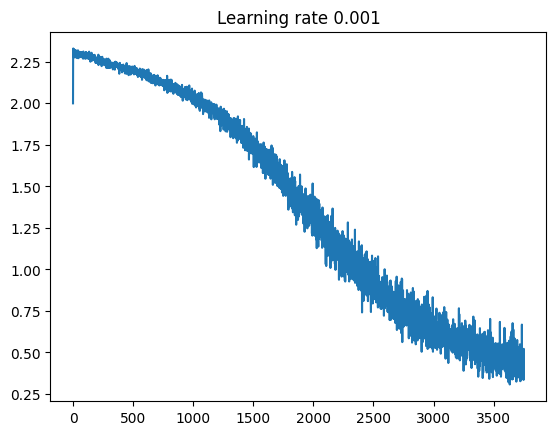

Learning rate: 0.0025, Step [1/938], epoch[0/4] Loss: 2.3352
Learning rate: 0.0025, Step [801/938], epoch[0/4] Loss: 1.2256
media de los errores en epoch 938 : 1.8517247090578333
Learning rate: 0.0025, Step [1/938], epoch[1/4] Loss: 0.9950
Learning rate: 0.0025, Step [801/938], epoch[1/4] Loss: 0.4193
media de los errores en epoch 938 : 1.2350651707557776
Learning rate: 0.0025, Step [1/938], epoch[2/4] Loss: 0.3022
Learning rate: 0.0025, Step [801/938], epoch[2/4] Loss: 0.2341
media de los errores en epoch 938 : 0.9234791284741347
Learning rate: 0.0025, Step [1/938], epoch[3/4] Loss: 0.2196
Learning rate: 0.0025, Step [801/938], epoch[3/4] Loss: 0.2016
media de los errores en epoch 938 : 0.744909447505415


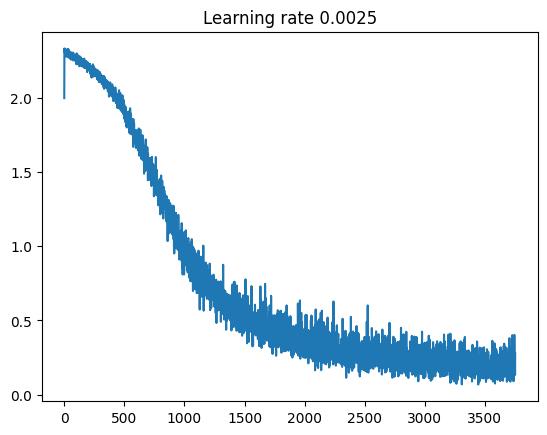

Learning rate: 0.005, Step [1/938], epoch[0/4] Loss: 2.3171
Learning rate: 0.005, Step [801/938], epoch[0/4] Loss: 0.3305
media de los errores en epoch 938 : 1.1053727215693527
Learning rate: 0.005, Step [1/938], epoch[1/4] Loss: 0.2808
Learning rate: 0.005, Step [801/938], epoch[1/4] Loss: 0.1408
media de los errores en epoch 938 : 0.6588577150675325
Learning rate: 0.005, Step [1/938], epoch[2/4] Loss: 0.2924
Learning rate: 0.005, Step [801/938], epoch[2/4] Loss: 0.0892
media de los errores en epoch 938 : 0.48592077009379864
Learning rate: 0.005, Step [1/938], epoch[3/4] Loss: 0.1236
Learning rate: 0.005, Step [801/938], epoch[3/4] Loss: 0.0964
media de los errores en epoch 938 : 0.39260565957549315


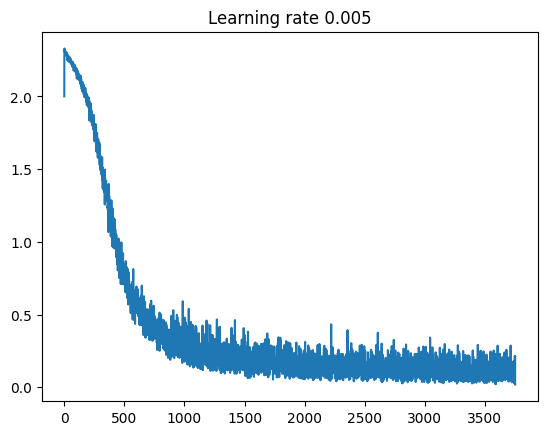

Learning rate: 0.01, Step [1/938], epoch[0/4] Loss: 2.2938
Learning rate: 0.01, Step [801/938], epoch[0/4] Loss: 0.1428
media de los errores en epoch 938 : 0.6827270020676243
Learning rate: 0.01, Step [1/938], epoch[1/4] Loss: 0.0695
Learning rate: 0.01, Step [801/938], epoch[1/4] Loss: 0.1550
media de los errores en epoch 938 : 0.4014683564748768
Learning rate: 0.01, Step [1/938], epoch[2/4] Loss: 0.1291
Learning rate: 0.01, Step [801/938], epoch[2/4] Loss: 0.0937
media de los errores en epoch 938 : 0.2961221816894957
Learning rate: 0.01, Step [1/938], epoch[3/4] Loss: 0.0903
Learning rate: 0.01, Step [801/938], epoch[3/4] Loss: 0.0570
media de los errores en epoch 938 : 0.2396823003648165


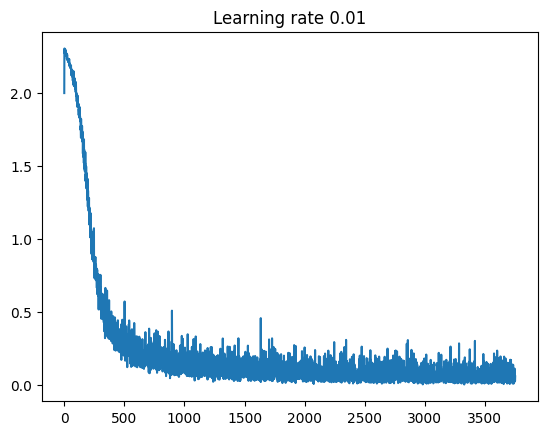

Learning rate: 0.02, Step [1/938], epoch[0/4] Loss: 2.2903
Learning rate: 0.02, Step [801/938], epoch[0/4] Loss: 0.2361
media de los errores en epoch 938 : 0.451239809504967
Learning rate: 0.02, Step [1/938], epoch[1/4] Loss: 0.0940
Learning rate: 0.02, Step [801/938], epoch[1/4] Loss: 0.0306
media de los errores en epoch 938 : 0.26983065244612237
Learning rate: 0.02, Step [1/938], epoch[2/4] Loss: 0.0845
Learning rate: 0.02, Step [801/938], epoch[2/4] Loss: 0.0426
media de los errores en epoch 938 : 0.20140363443212758
Learning rate: 0.02, Step [1/938], epoch[3/4] Loss: 0.1227
Learning rate: 0.02, Step [801/938], epoch[3/4] Loss: 0.0052
media de los errores en epoch 938 : 0.16430114805172308


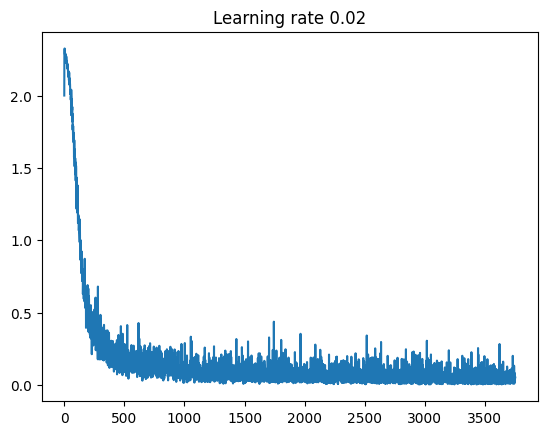

Learning rate: 0.03, Step [1/938], epoch[0/4] Loss: 2.3026
Learning rate: 0.03, Step [801/938], epoch[0/4] Loss: 0.0753
media de los errores en epoch 938 : 0.3652552973649626
Learning rate: 0.03, Step [1/938], epoch[1/4] Loss: 0.1253
Learning rate: 0.03, Step [801/938], epoch[1/4] Loss: 0.1099
media de los errores en epoch 938 : 0.21923329757817275
Learning rate: 0.03, Step [1/938], epoch[2/4] Loss: 0.0356


In [ ]:
########### MINI BATCH SGD #######################

#lr=0.05
epochs=4

lrv = [0.001, 0.0025, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05,  0.06, 0.07, 0.08, 0.09]

for lr in lrv:
  model = LeNet5(n_classes).to(device)
  train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = 64,
                                            shuffle = True)

  optimizer = torch.optim.SGD(model.parameters(), lr=lr)



  errores = np.array(2.0)

  for i in range(epochs):
    for j, (images, labels) in enumerate(train_loader):
      #Convierto las imagenes según el dispositivo que uso
      images = images.to(device)
      labels = labels.to(device)

      ## Paso adelante
      #Hago una prediccion (creo que calcular el gradiente)
      outputs = model(images)

      #Calculo la funcion de coste
      loss = cost(outputs, labels)

      ##Paso atras
      #Reseteo los gradientes de la iteracion anterior.
      optimizer.zero_grad()
      #Calculo los nuevos gradientes
      loss.backward()
      #Actualizo los pesos (para llamar a ésta función tengo que haber llamado antes a backward())
      optimizer.step()

      errores = np.append(errores, loss.item())

      if j%800==0:
        print ('Learning rate: {}, Step [{}/{}], epoch[{}/{}] Loss: {:.4f}'
                  .format(lr, j+1, len(train_loader), i, epochs, loss.item()))
    print("media de los errores en epoch {} : {}".format(i+1, np.mean(errores) ))
  plt.plot(errores)
  plt.title("Learning rate {}".format(lr))
  plt.show()




Learning rate: 0.001, Step [1/938], epoch[0/4] Loss: 2.3101
Learning rate: 0.001, Step [801/938], epoch[0/4] Loss: 0.0253
Media de errores en epoch 1 : 0.1633134256223667
Learning rate: 0.001, Step [1/938], epoch[1/4] Loss: 0.1348
Learning rate: 0.001, Step [801/938], epoch[1/4] Loss: 0.1083
Media de errores en epoch 2 : 0.10883498339445892
Learning rate: 0.001, Step [1/938], epoch[2/4] Loss: 0.0316
Learning rate: 0.001, Step [801/938], epoch[2/4] Loss: 0.0460
Media de errores en epoch 3 : 0.08598465824272893
Learning rate: 0.001, Step [1/938], epoch[3/4] Loss: 0.0055
Learning rate: 0.001, Step [801/938], epoch[3/4] Loss: 0.1530
Media de errores en epoch 4 : 0.07272325490453616


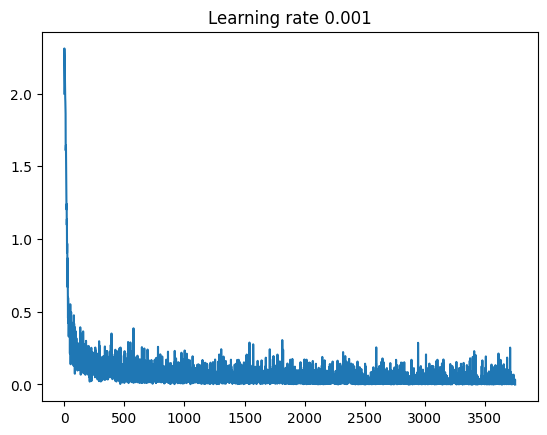

Learning rate: 0.0025, Step [1/938], epoch[0/4] Loss: 2.2686
Learning rate: 0.0025, Step [801/938], epoch[0/4] Loss: 0.0910
Media de errores en epoch 1 : 0.13243798047209435
Learning rate: 0.0025, Step [1/938], epoch[1/4] Loss: 0.0049
Learning rate: 0.0025, Step [801/938], epoch[1/4] Loss: 0.0065
Media de errores en epoch 2 : 0.09257394803395683
Learning rate: 0.0025, Step [1/938], epoch[2/4] Loss: 0.0704
Learning rate: 0.0025, Step [801/938], epoch[2/4] Loss: 0.0014
Media de errores en epoch 3 : 0.07554682271247899
Learning rate: 0.0025, Step [1/938], epoch[3/4] Loss: 0.0081
Learning rate: 0.0025, Step [801/938], epoch[3/4] Loss: 0.1268
Media de errores en epoch 4 : 0.06495730159497522


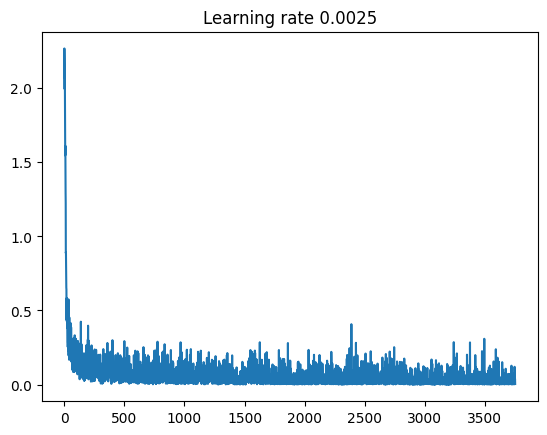

Learning rate: 0.005, Step [1/938], epoch[0/4] Loss: 2.2809
Learning rate: 0.005, Step [801/938], epoch[0/4] Loss: 0.0223
Media de errores en epoch 1 : 0.136490710298863
Learning rate: 0.005, Step [1/938], epoch[1/4] Loss: 0.0695
Learning rate: 0.005, Step [801/938], epoch[1/4] Loss: 0.2129
Media de errores en epoch 2 : 0.09731272697151894
Learning rate: 0.005, Step [1/938], epoch[2/4] Loss: 0.1351
Learning rate: 0.005, Step [801/938], epoch[2/4] Loss: 0.0593
Media de errores en epoch 3 : 0.08029561942814623
Learning rate: 0.005, Step [1/938], epoch[3/4] Loss: 0.0338
Learning rate: 0.005, Step [801/938], epoch[3/4] Loss: 0.0177
Media de errores en epoch 4 : 0.06996875480021808


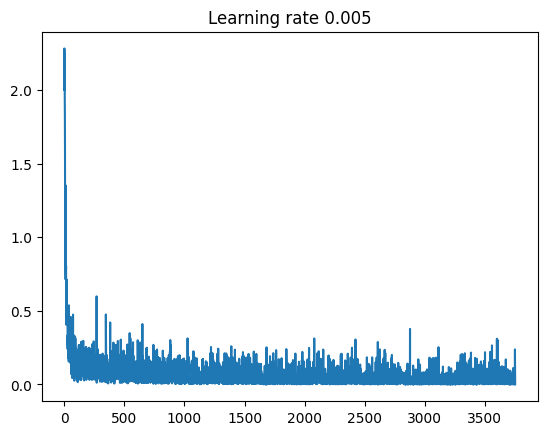

Learning rate: 0.01, Step [1/938], epoch[0/4] Loss: 2.3202
Learning rate: 0.01, Step [801/938], epoch[0/4] Loss: 0.1270
Media de errores en epoch 1 : 0.1464924011134004
Learning rate: 0.01, Step [1/938], epoch[1/4] Loss: 0.0299
Learning rate: 0.01, Step [801/938], epoch[1/4] Loss: 0.0437
Media de errores en epoch 2 : 0.10664659225442599
Learning rate: 0.01, Step [1/938], epoch[2/4] Loss: 0.0294
Learning rate: 0.01, Step [801/938], epoch[2/4] Loss: 0.0391
Media de errores en epoch 3 : 0.09003180996014974
Learning rate: 0.01, Step [1/938], epoch[3/4] Loss: 0.2069
Learning rate: 0.01, Step [801/938], epoch[3/4] Loss: 0.0191
Media de errores en epoch 4 : 0.07999766359942552


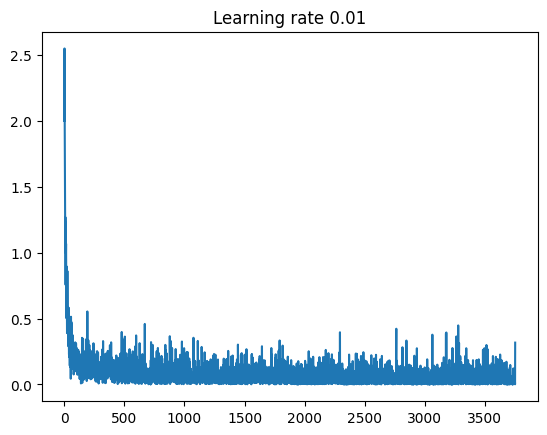

Learning rate: 0.02, Step [1/938], epoch[0/4] Loss: 2.3202
Learning rate: 0.02, Step [801/938], epoch[0/4] Loss: 0.0400
Media de errores en epoch 1 : 0.23159465176862673
Learning rate: 0.02, Step [1/938], epoch[1/4] Loss: 0.0663
Learning rate: 0.02, Step [801/938], epoch[1/4] Loss: 0.1433
Media de errores en epoch 2 : 0.1649244426848634
Learning rate: 0.02, Step [1/938], epoch[2/4] Loss: 0.1273
Learning rate: 0.02, Step [801/938], epoch[2/4] Loss: 0.0399
Media de errores en epoch 3 : 0.13926459991699416
Learning rate: 0.02, Step [1/938], epoch[3/4] Loss: 0.1652
Learning rate: 0.02, Step [801/938], epoch[3/4] Loss: 0.2478
Media de errores en epoch 4 : 0.12542564861207237


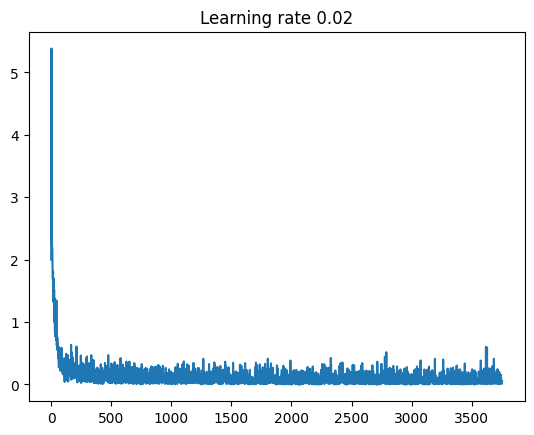

Learning rate: 0.03, Step [1/938], epoch[0/4] Loss: 2.3036
Learning rate: 0.03, Step [801/938], epoch[0/4] Loss: 0.1788
Media de errores en epoch 1 : 0.2754995006818971
Learning rate: 0.03, Step [1/938], epoch[1/4] Loss: 0.0605
Learning rate: 0.03, Step [801/938], epoch[1/4] Loss: 0.0337
Media de errores en epoch 2 : 0.19352321214063442
Learning rate: 0.03, Step [1/938], epoch[2/4] Loss: 0.0691
Learning rate: 0.03, Step [801/938], epoch[2/4] Loss: 0.3218
Media de errores en epoch 3 : 0.16541186020152104
Learning rate: 0.03, Step [1/938], epoch[3/4] Loss: 0.1852
Learning rate: 0.03, Step [801/938], epoch[3/4] Loss: 0.0912
Media de errores en epoch 4 : 0.14821082471657465


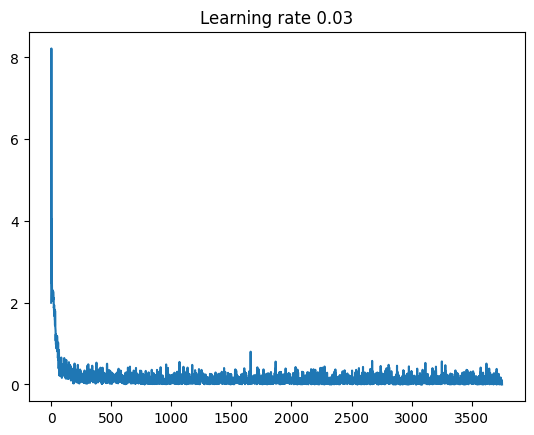

Learning rate: 0.04, Step [1/938], epoch[0/4] Loss: 2.3470
Learning rate: 0.04, Step [801/938], epoch[0/4] Loss: 0.1950
Media de errores en epoch 1 : 0.31282370495862855
Learning rate: 0.04, Step [1/938], epoch[1/4] Loss: 0.4775
Learning rate: 0.04, Step [801/938], epoch[1/4] Loss: 0.1599
Media de errores en epoch 2 : 0.24191454272086102
Learning rate: 0.04, Step [1/938], epoch[2/4] Loss: 0.4097
Learning rate: 0.04, Step [801/938], epoch[2/4] Loss: 0.0890
Media de errores en epoch 3 : 0.2202878867185031
Learning rate: 0.04, Step [1/938], epoch[3/4] Loss: 0.0562
Learning rate: 0.04, Step [801/938], epoch[3/4] Loss: 0.1597
Media de errores en epoch 4 : 0.20657092958560688


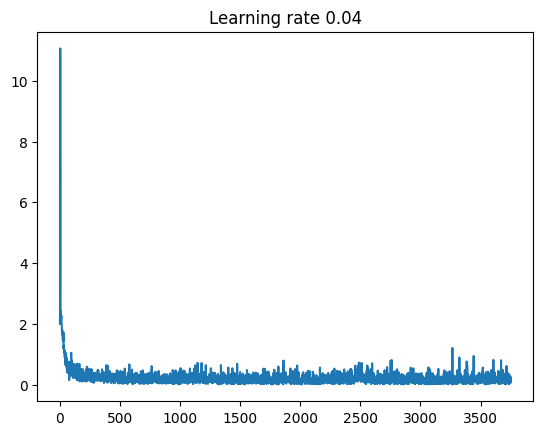

Learning rate: 0.05, Step [1/938], epoch[0/4] Loss: 2.3311
Learning rate: 0.05, Step [801/938], epoch[0/4] Loss: 0.2046
Media de errores en epoch 1 : 0.4655209899700472
Learning rate: 0.05, Step [1/938], epoch[1/4] Loss: 0.1106
Learning rate: 0.05, Step [801/938], epoch[1/4] Loss: 0.1083
Media de errores en epoch 2 : 0.3356852831361646
Learning rate: 0.05, Step [1/938], epoch[2/4] Loss: 0.2652
Learning rate: 0.05, Step [801/938], epoch[2/4] Loss: 0.1567
Media de errores en epoch 3 : 0.2950872273640922
Learning rate: 0.05, Step [1/938], epoch[3/4] Loss: 0.1720
Learning rate: 0.05, Step [801/938], epoch[3/4] Loss: 0.5024
Media de errores en epoch 4 : 0.2706813576304677


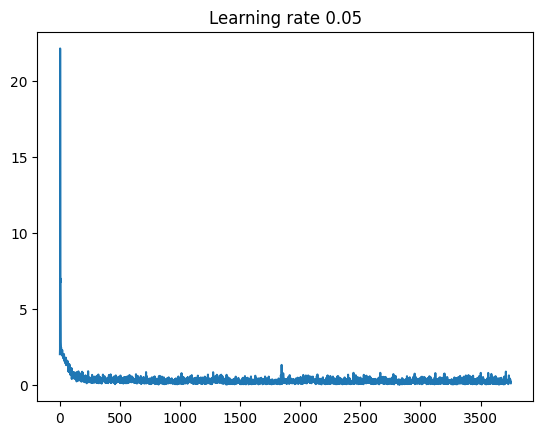

Learning rate: 0.06, Step [1/938], epoch[0/4] Loss: 2.3187
Learning rate: 0.06, Step [801/938], epoch[0/4] Loss: 0.1402
Media de errores en epoch 1 : 0.5451219973329919
Learning rate: 0.06, Step [1/938], epoch[1/4] Loss: 0.1074
Learning rate: 0.06, Step [801/938], epoch[1/4] Loss: 0.4023
Media de errores en epoch 2 : 0.42838322524662087
Learning rate: 0.06, Step [1/938], epoch[2/4] Loss: 0.6189
Learning rate: 0.06, Step [801/938], epoch[2/4] Loss: 0.0889
Media de errores en epoch 3 : 0.3729814517058657
Learning rate: 0.06, Step [1/938], epoch[3/4] Loss: 0.2369
Learning rate: 0.06, Step [801/938], epoch[3/4] Loss: 0.1730
Media de errores en epoch 4 : 0.35721660244940934


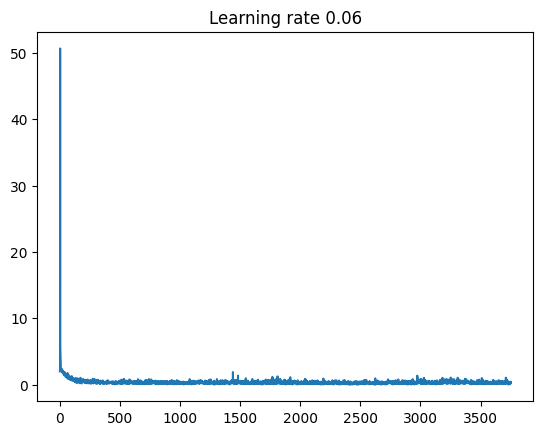

Learning rate: 0.07, Step [1/938], epoch[0/4] Loss: 2.3253
Learning rate: 0.07, Step [801/938], epoch[0/4] Loss: 0.7096
Media de errores en epoch 1 : 1.1522780453371673
Learning rate: 0.07, Step [1/938], epoch[1/4] Loss: 0.5556
Learning rate: 0.07, Step [801/938], epoch[1/4] Loss: 0.2804
Media de errores en epoch 2 : 0.8232959859315296
Learning rate: 0.07, Step [1/938], epoch[2/4] Loss: 0.5251
Learning rate: 0.07, Step [801/938], epoch[2/4] Loss: 0.1676
Media de errores en epoch 3 : 0.6811019201010307
Learning rate: 0.07, Step [1/938], epoch[3/4] Loss: 0.3517
Learning rate: 0.07, Step [801/938], epoch[3/4] Loss: 0.2260
Media de errores en epoch 4 : 0.6024354167387799


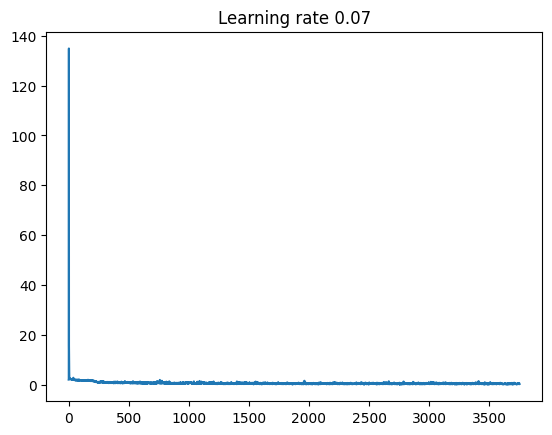

Learning rate: 0.08, Step [1/938], epoch[0/4] Loss: 2.3367
Learning rate: 0.08, Step [801/938], epoch[0/4] Loss: 0.5014
Media de errores en epoch 1 : 0.4626508688720794
Learning rate: 0.08, Step [1/938], epoch[1/4] Loss: 0.4199
Learning rate: 0.08, Step [801/938], epoch[1/4] Loss: 0.2196
Media de errores en epoch 2 : 0.37140883112422524
Learning rate: 0.08, Step [1/938], epoch[2/4] Loss: 0.2638
Learning rate: 0.08, Step [801/938], epoch[2/4] Loss: 0.3098
Media de errores en epoch 3 : 0.3630678178620116
Learning rate: 0.08, Step [1/938], epoch[3/4] Loss: 0.2354
Learning rate: 0.08, Step [801/938], epoch[3/4] Loss: 1.2595
Media de errores en epoch 4 : 0.49435653787403067


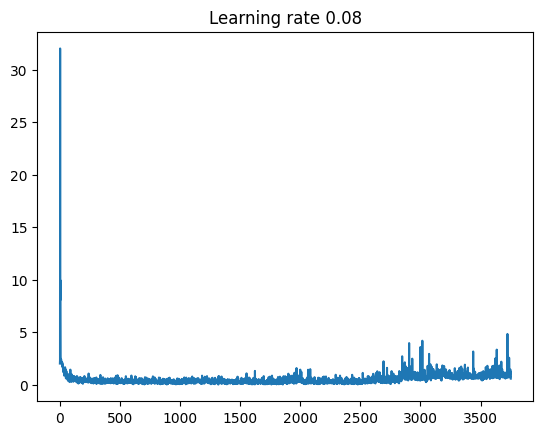

Learning rate: 0.09, Step [1/938], epoch[0/4] Loss: 2.3258
Learning rate: 0.09, Step [801/938], epoch[0/4] Loss: 2.3196
Media de errores en epoch 1 : 2.439421147965014
Learning rate: 0.09, Step [1/938], epoch[1/4] Loss: 2.2951
Learning rate: 0.09, Step [801/938], epoch[1/4] Loss: 2.3179
Media de errores en epoch 2 : 2.374083137283569
Learning rate: 0.09, Step [1/938], epoch[2/4] Loss: 2.3084
Learning rate: 0.09, Step [801/938], epoch[2/4] Loss: 2.3158
Media de errores en epoch 3 : 2.3528197717920714
Learning rate: 0.09, Step [1/938], epoch[3/4] Loss: 2.2966
Learning rate: 0.09, Step [801/938], epoch[3/4] Loss: 2.3039
Media de errores en epoch 4 : 2.3420146613828727


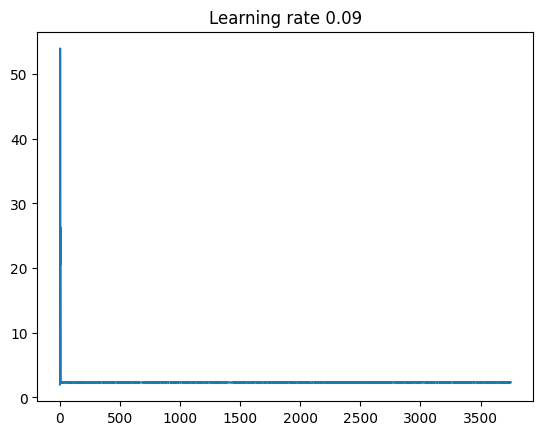

In [ ]:
from numpy.core.fromnumeric import mean
############ ADAM #######


epochs=4

lrv = [0.001, 0.0025, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05,  0.06, 0.07, 0.08, 0.09]

for lr in lrv:
  model = LeNet5(n_classes).to(device)
  train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = 64,
                                            shuffle = True)

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)



  errores = np.array(2.0)

  for i in range(epochs):
    for j, (images, labels) in enumerate(train_loader):
      #Convierto las imagenes según el dispositivo que uso
      images = images.to(device)
      labels = labels.to(device)

      ## Paso adelante
      #Hago una prediccion (creo que calcular el gradiente)
      outputs = model(images)

      #Calculo la funcion de coste
      loss = cost(outputs, labels)

      ##Paso atras
      #Reseteo los gradientes de la iteracion anterior.
      optimizer.zero_grad()
      #Calculo los nuevos gradientes
      loss.backward()
      #Actualizo los pesos (para llamar a ésta función tengo que haber llamado antes a backward())
      optimizer.step()

      errores = np.append(errores, loss.item())

      if j%800==0:
        print ('Learning rate: {}, Step [{}/{}], epoch[{}/{}] Loss: {:.4f}'
                  .format(lr, j+1, len(train_loader), i, epochs, loss.item()))
    print("Media de errores en epoch {} : {}".format(i+1, np.mean(errores)))

  plt.plot(errores)
  plt.title("Learning rate {}".format(lr))
  plt.show()



###Resumen
1. Cargo el dataset, decido no hacer normalizacion.
2. Meto en un data_loader para ir metiendo datos.
3. Creo la Red LeNet5. Le paso la cantidad de labels (output) y la conecto al dispositivo
4. Elijo la función de pérdida y el algoritmo que voy a usar (sgd sin momentum)
5. Corro el aprendizaje


###TODO
- Registrar tiempos
- Ver cómo funciona el batch size -> batch size tamaño de "paquetes" que cargo en el data_loader. Si es m solo cargo un paquete, si es 1 cada objeto del dataset es un paquete. Cada epoch se basa en iterar sobre los distintos paquetes que haya, calcular el gradiente basandome en los ouputs y val reales de los objetos en ese paquete y actualizar los pesos en base a eso, luego paso al siguiente paquete.
- Ahora la cosa es cómo selecciono eficientemente una muestra aleatoria
- Pintar gráficas
- Ver generalizacion

In [ ]:
####
#### ALGORITMO GENETICO
####

ga_model = LeNet5(n_classes)

GACNN_instance = pygad.gacnn.GACNN(model=ga_model, num_solutions=10)
lossf = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = 60000, #puro sgd
                                           shuffle = True)
for (data, label) in train_loader:
  datos=data
  #prediction = ga_model(data)
  values = label

#loss = lossf(prediction, values).detach()



In [ ]:
def fitness_func(ga_instance, solution, sol_idx):
    global GACNN_instance, datos, values

    predictions = GACNN_instance.population_networks[sol_idx].predict(data_inputs=datos)
    correct_predictions = numpy.where(predictions == values)[0].size
    solution_fitness = (correct_predictions/values.size)*100

    return solution_fitness

In [ ]:
num_generations = 250
num_parents_mating = 5
#population does not hold the numerical weights of the network instead it holds a list of references to each last layer of each network (i.e. solution) in the population. A solution or a network can be used interchangeably.
# If there is a population with 3 solutions (i.e. networks), then the population is a list with 3 elements. Each element is a reference to the last layer of each network. Using such a reference, all details of the network can be accessed.
population_vectors = pygad.gacnn.population_as_vectors(population_networks=GACNN_instance.population_networks)

# To prepare the initial population, there are 2 ways:
# 1) Prepare it yourself and pass it to the initial_population parameter. This way is useful when the user wants to start the genetic algorithm with a custom initial population.
# 2) Assign valid integer values to the sol_per_pop and num_genes parameters. If the initial_population parameter exists, then the sol_per_pop and num_genes parameters are useless.
initial_population = population_vectors.copy()

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_func)

AttributeError: ignored

In [ ]:
ga_instance.run()

Learning rate: 0.001, Step [1/5000], Loss: 2.2118
Learning rate: 0.001, Step [51/5000], Loss: 2.2179
Learning rate: 0.001, Step [101/5000], Loss: 2.2493
Learning rate: 0.001, Step [151/5000], Loss: 2.2075
Learning rate: 0.001, Step [201/5000], Loss: 2.2508
Learning rate: 0.001, Step [251/5000], Loss: 2.2080
Learning rate: 0.001, Step [301/5000], Loss: 2.3074
Learning rate: 0.001, Step [351/5000], Loss: 2.2732
Learning rate: 0.001, Step [401/5000], Loss: 2.2544
Learning rate: 0.001, Step [451/5000], Loss: 2.2693
Learning rate: 0.001, Step [501/5000], Loss: 2.3801
Learning rate: 0.001, Step [551/5000], Loss: 2.3151
Learning rate: 0.001, Step [601/5000], Loss: 2.1430
Learning rate: 0.001, Step [651/5000], Loss: 2.3591
Learning rate: 0.001, Step [701/5000], Loss: 2.1156
Learning rate: 0.001, Step [751/5000], Loss: 2.1890
Learning rate: 0.001, Step [801/5000], Loss: 2.3653
Learning rate: 0.001, Step [851/5000], Loss: 2.0883
Learning rate: 0.001, Step [901/5000], Loss: 2.1720
Learning rate: 

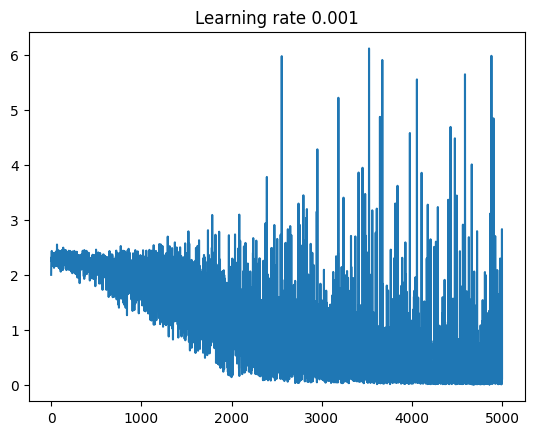

#########CAMBIO#######
Learning rate: 0.05, Step [1/5000], Loss: 2.6065
Learning rate: 0.05, Step [51/5000], Loss: 2.1130
Learning rate: 0.05, Step [101/5000], Loss: 2.2294
Learning rate: 0.05, Step [151/5000], Loss: 2.0946
Learning rate: 0.05, Step [201/5000], Loss: 3.0095
Learning rate: 0.05, Step [251/5000], Loss: 0.0378
Learning rate: 0.05, Step [301/5000], Loss: 2.3336
Learning rate: 0.05, Step [351/5000], Loss: 1.7028
Learning rate: 0.05, Step [401/5000], Loss: 0.0284
Learning rate: 0.05, Step [451/5000], Loss: 0.2602
Learning rate: 0.05, Step [501/5000], Loss: 1.9562
Learning rate: 0.05, Step [551/5000], Loss: 0.0511
Learning rate: 0.05, Step [601/5000], Loss: 0.3060
Learning rate: 0.05, Step [651/5000], Loss: 0.1888
Learning rate: 0.05, Step [701/5000], Loss: 0.3885
Learning rate: 0.05, Step [751/5000], Loss: 0.0051
Learning rate: 0.05, Step [801/5000], Loss: 0.2205
Learning rate: 0.05, Step [851/5000], Loss: 0.0786
Learning rate: 0.05, Step [901/5000], Loss: 0.0063
Learning ra

KeyboardInterrupt: ignored

In [ ]:
#########################PLAYGROUND VARIOS SGD PURO#############3
epochs = 5000
lr=0.001

#0.045<x<0.08
model = LeNet5(n_classes).to(device)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = 1, #puro sgd
                                           shuffle = True)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

enum = enumerate(train_loader)
aux, data = next(enum)

errores = np.array(2.0)

for i in range(epochs):
  #Convierto las imagenes según el dispositivo que uso
  aux, (images, labels) = next(enum)
  images = images.to(device)
  labels = labels.to(device)

  ## Paso adelante
  #Hago una prediccion (creo que calcular el gradiente)
  outputs = model(images)

  #Calculo la funcion de coste
  loss = cost(outputs, labels)

  ##Paso atras
  #Reseteo los gradientes de la iteracion anterior.
  optimizer.zero_grad()
  #Calculo los nuevos gradientes
  loss.backward()
  #Actualizo los pesos (para llamar a ésta función tengo que haber llamado antes a backward())
  optimizer.step()

  errores = np.append(errores, loss.item())

  if i%50==0:
    print ('Learning rate: {}, Step [{}/{}], Loss: {:.4f}'
              .format(lr, i+1, epochs, loss.item()))

plt.plot(errores)
plt.title("Learning rate {}".format(lr))
plt.show()


print("#########CAMBIO#######")


errores = np.array(2.0)
lr=0.05
model = LeNet5(n_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = 1, #puro sgd
                                           shuffle = True)

enum = enumerate(train_loader)
aux, data = next(enum)


for i in range(epochs):
  #Convierto las imagenes según el dispositivo que uso
  aux, (images, labels) = next(enum)
  images = images.to(device)
  labels = labels.to(device)
  ## Paso adelante
  #Hago una prediccion (creo que calcular el gradiente)
  outputs = model(images)

  #Calculo la funcion de coste
  loss = cost(outputs, labels)

  ##Paso atras
  #Reseteo los gradientes de la iteracion anterior.
  optimizer.zero_grad()
  #Calculo los nuevos gradientes
  loss.backward()
  #Actualizo los pesos (para llamar a ésta función tengo que haber llamado antes a backward())
  optimizer.step()

  errores = np.append(errores, loss.item())

  if i%50==0:
    print ('Learning rate: {}, Step [{}/{}], Loss: {:.4f}'
              .format(lr, i+1, epochs, loss.item()))



plt.plot(errores)
plt.title("Learning rate {}".format(lr))
plt.show()


print("#########CAMBIO#######")
lr=0.05
errores = np.array(2.0)
model = LeNet5(n_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = 1, #puro sgd
                                           shuffle = True)

enum = enumerate(train_loader)
aux, data = next(enum)


for i in range(epochs):
  #Convierto las imagenes según el dispositivo que uso
  aux, (images, labels) = next(enum)
  images = images.to(device)
  labels = labels.to(device)
  ## Paso adelante
  #Hago una prediccion (creo que calcular el gradiente)
  outputs = model(images)

  #Calculo la funcion de coste
  loss = cost(outputs, labels)

  ##Paso atras
  #Reseteo los gradientes de la iteracion anterior.
  optimizer.zero_grad()
  #Calculo los nuevos gradientes
  loss.backward()
  #Actualizo los pesos (para llamar a ésta función tengo que haber llamado antes a backward())
  optimizer.step()

  errores = np.append(errores, loss.item())


  if i%50==0:
    print ('Learning rate: {}, Step [{}/{}], Loss: {:.4f}'
              .format(lr, i+1, epochs, loss.item()))

plt.plot(errores)
plt.title("Learning rate {}".format(lr))
plt.show()


print("#########CAMBIO#######")
lr=0.05
errores = np.array(2.0)
model = LeNet5(n_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = 1, #puro sgd
                                           shuffle = True)

enum = enumerate(train_loader)
aux, data = next(enum)


for i in range(epochs):
  #Convierto las imagenes según el dispositivo que uso
  aux, (images, labels) = next(enum)
  images = images.to(device)
  labels = labels.to(device)
  ## Paso adelante
  #Hago una prediccion (creo que calcular el gradiente)
  outputs = model(images)

  #Calculo la funcion de coste
  loss = cost(outputs, labels)

  ##Paso atras
  #Reseteo los gradientes de la iteracion anterior.
  optimizer.zero_grad()
  #Calculo los nuevos gradientes
  loss.backward()
  #Actualizo los pesos (para llamar a ésta función tengo que haber llamado antes a backward())
  optimizer.step()

  errores = np.append(errores, loss.item())
  if i%50==0:
    print ('Learning rate: {}, Step [{}/{}], Loss: {:.4f}'
              .format(lr, i+1, epochs, loss.item()))


plt.plot(errores)
plt.title("Learning rate {}".format(lr))
plt.show()


print("#########CAMBIO#######")
lr=0.07
errores = np.array(2.0)
model = LeNet5(n_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = 1, #puro sgd
                                           shuffle = True)

enum = enumerate(train_loader)
aux, data = next(enum)


for i in range(epochs):
  #Convierto las imagenes según el dispositivo que uso
  aux, (images, labels) = next(enum)
  images = images.to(device)
  labels = labels.to(device)
  ## Paso adelante
  #Hago una prediccion (creo que calcular el gradiente)
  outputs = model(images)

  #Calculo la funcion de coste
  loss = cost(outputs, labels)

  ##Paso atras
  #Reseteo los gradientes de la iteracion anterior.
  optimizer.zero_grad()
  #Calculo los nuevos gradientes
  loss.backward()
  #Actualizo los pesos (para llamar a ésta función tengo que haber llamado antes a backward())
  optimizer.step()

  errores = np.append(errores, loss.item())


  if i%50==0:
    print ('Learning rate: {}, Step [{}/{}], Loss: {:.4f}'
              .format(lr, i+1, epochs, loss.item()))

plt.plot(errores)
plt.title("Learning rate {}".format(lr))
plt.show()